<a href="https://colab.research.google.com/github/haein0224/kaggle/blob/main/Titanic_Top_4_with_ensemble_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [ ]:
# Load data
##### Load train and Test set

train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/titanic/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/titanic/test.csv")
IDtest = test["PassengerId"]

In [ ]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [ ]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [ ]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [ ]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

2.4 check for null and missing values

In [ ]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

# Survied에 대한 missing값은 test set과 결합때문이고, 
# Age와 Cabin에서 많은 양의 missing이 있음이 확인됨

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [ ]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
### Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


### 3. Feature analysis
3.1 Numerical values

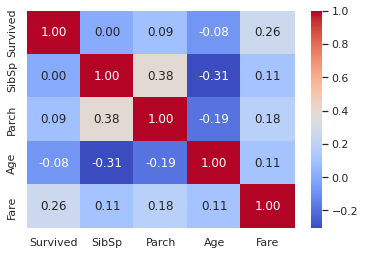

In [ ]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot=True, fmt=".2f", cmap = 'coolwarm')

# 전반적으로 생존과 연관이있는 변수는 Fare정도인것으로 보임
# 하지만 다른 변수들이 의미 없는 것은 아니므로 특징 확인 필요

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


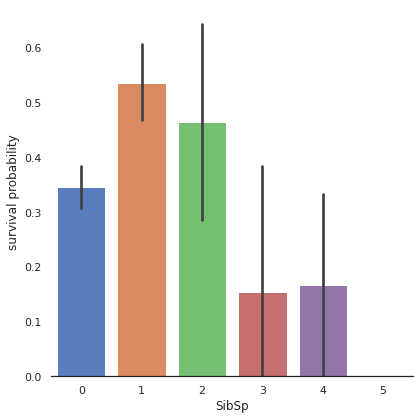

In [ ]:
# SibSp
# Explore SibSp fearue vs Suvived
g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size = 6, palette = 'muted')
g.despine(left=True) # 왼쪽 축을 출력하지 않음
g = g.set_ylabels("survival probability")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


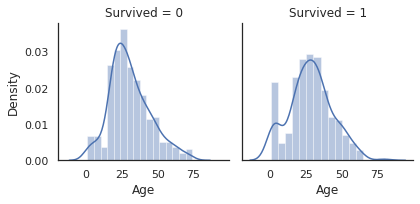

In [ ]:
# Age
# Explore Age vs Survived
g = sns.FacetGrid(train,col='Survived') # 생존여부(범주형)에 따라
g = g.map(sns.distplot, "Age") # 연령의 분포를 살펴봄

# Facet Grid : 다양한 범주형 값을 가지는 데이터를 시각화하는데 좋은 방법
# 행, 열 방향으로 서로 다른 조건을 적용하여 여러 개의 서브 플롯 제작
# 각 서브 플롯에 적용할 그래프 종류를 map() 메서드를 이용하여 그리드 객체에 전달
# https://steadiness-193.tistory.com/201

# 해석 : 가우시안 형태 / 생존 측면에서 어린 연령층의 많음(숫자가 튐), 연령대가 높은 경우 생존 못한 경우가 더 많음
# -> 위에서 공분산 행렬에서는 두 변수 사이에 연관이 없다고했으나, 연령대(범주화)가 영향이 있음을 알 수 있음

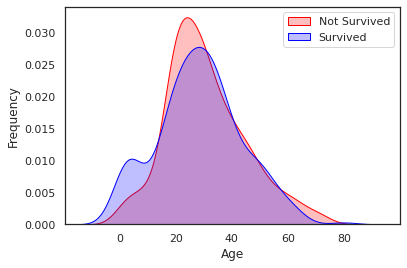

In [ ]:
# Eplore Age distribution 
g = sns.kdeplot(train['Age'][(train['Survived']==0)&(train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1)& (train['Age'].notnull())], ax=g, color="Blue", shade = True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(['Not Survived', 'Survived'])

In [ ]:
# Fare
print(dataset["Fare"].isnull().sum())

# Fill Fare missing values with the median value
dataset['Fare'] = dataset["Fare"].fillna(dataset['Fare'].median())

1


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


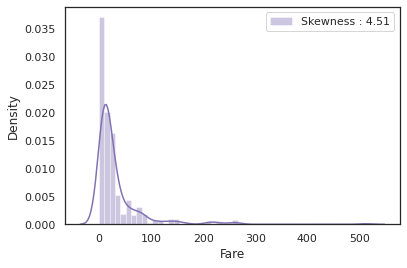

In [ ]:
# Explore Fare distribution
g = sns.distplot(dataset['Fare'], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

# skewness가 높은 편 -> scaled되었다고 해도 overweight이 발생할 수 있음 -> 따라서 log function을 고려

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


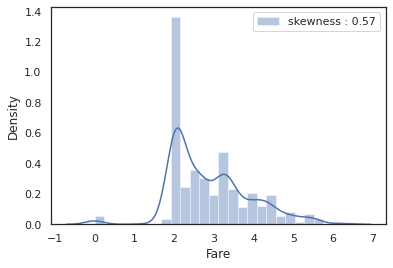

In [ ]:
# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i : np.log(i) if i > 0 else 0) # 값이 0 인경우는 그냥 0으로 둠(로그함수는 0에서 정의되지 않으므로!)

g = sns.distplot(dataset['Fare'], color="b", label="skewness : %.2f"%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

# skweness가 많이 완화된 것을 볼 수 ㅇ

3.2 Categorical values

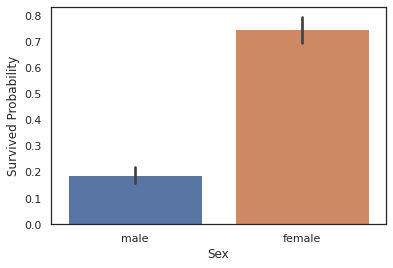

In [ ]:
# Sex
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel("Survived Probability")

In [ ]:
train[['Sex', 'Survived']].groupby('Sex').mean() # 성별에 따른 생존자 비율(Survived값이 1,0이므로 평균내면 생존율 나옴)
# 성별에 따른 생존율 차이 확실히 있음 -> 예측에 중요한 역할 을 할것으로 예상됨

,Survived
Sex,
female,0.747573
male,0.190559


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


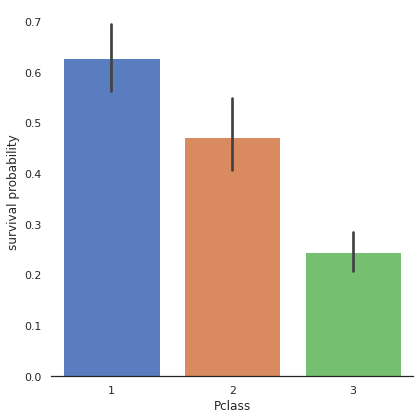

In [ ]:
# Pclass
# Explore Pclass vs Survived
g = sns.factorplot(x="Pclass", y = "Survived", data=train, kind='bar', size=6, palette = "muted") # kind를 bar로 설정했으므로 barplot이 나옴
g.despine(left = True)
g = g.set_ylabels("survival probability")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


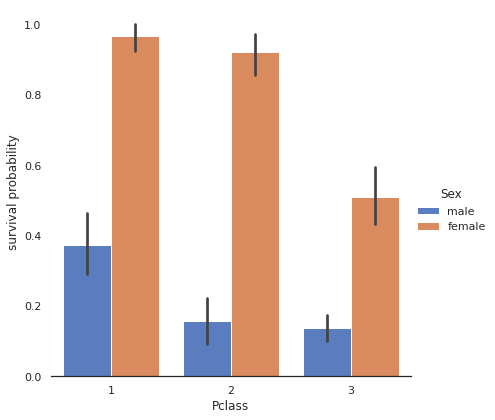

In [ ]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x = "Pclass", y="Survived", hue="Sex", data=train, size=6, kind='bar', palette = "muted") # hue를 이용해서 기준을 나눔
g.despine(left=True) # 왼쪽 축이 안나오게 함
g = g.set_ylabels("survival probability")

# class 1 의 승객들의 survival probability 더 높음

In [ ]:
# Embarked
print(dataset['Embarked'].isnull().sum())

# FIll Embarked nan values of dataset set with 'S' most frequent value
print(dataset['Embarked'].groupby(dataset['Embarked']).count())

dataset['Embarked'] = dataset['Embarked'].fillna("S")

2
Embarked
C    270
Q    123
S    904
Name: Embarked, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


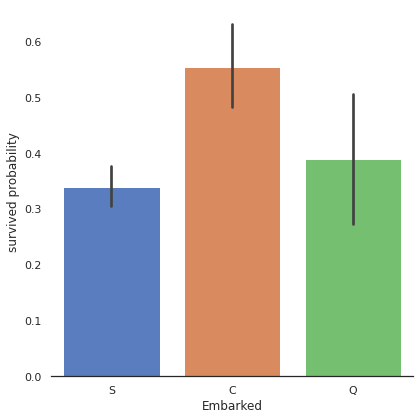

In [ ]:
# Explore Emabrarked vs Survived
g = sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind='bar', palette="muted")
g.despine(left=True)
g = g.set_ylabels("survived probability")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


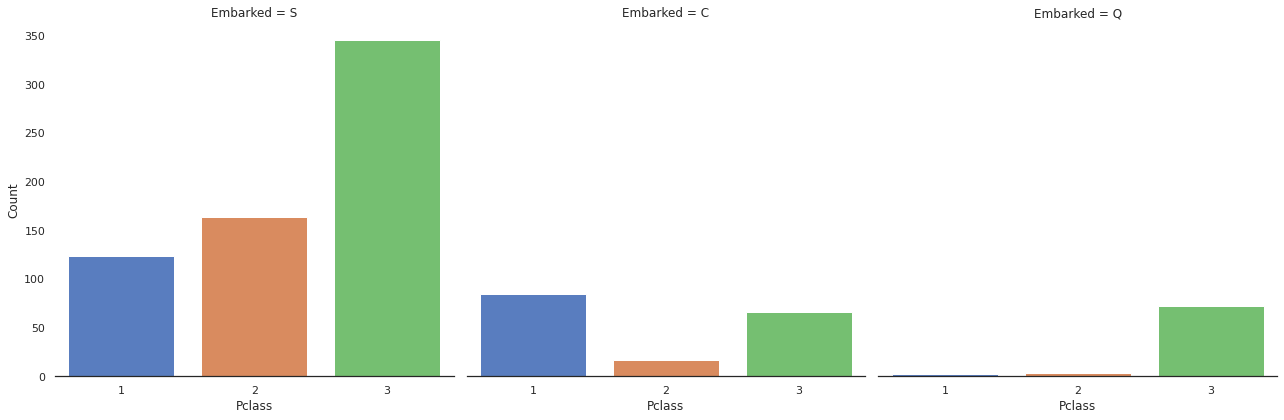

In [ ]:
# Explore Pclass vs Emabarked
g = sns.factorplot("Pclass", col='Embarked', data = train, size = 6, kind='count', palette='muted') # Embarked에 따라 column을 나눠서 그림
g.despine(left=True)
g = g.set_ylabels("Count")

# C항구에서 탑승한 승객의 생존율이 높았는데 class1 승객의 비율이 높음을 확인할 수 있음

### Filling missing Values
4.1 Age

In [ ]:
dataset['Age'].isnull().sum() # 나이대(어린이 등)가 생존여부에 영향을 미치므로 가져가고싶음

256

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

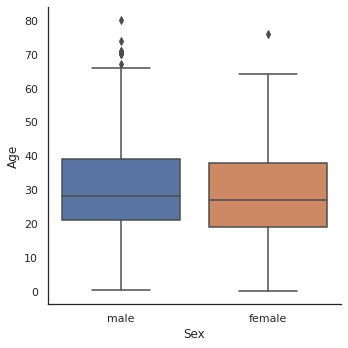

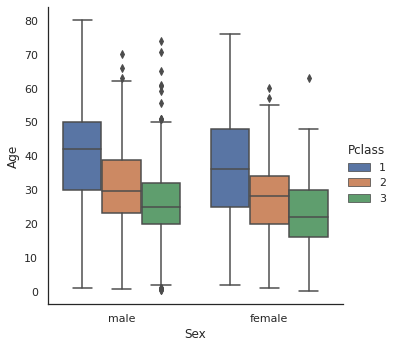

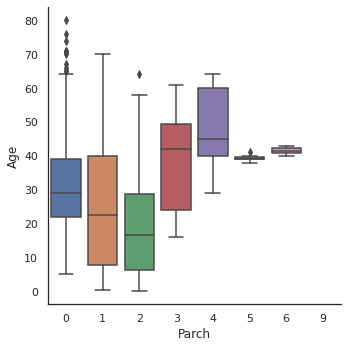

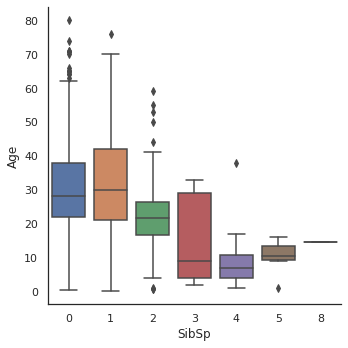

In [ ]:
# Explor Age vs Sex, Parch, Pclass and SIbSp
g = sns.factorplot(y='Age',x='Sex', data=dataset, kind = 'box') # 분포에 큰 차이 x : 나이 결측치 예측에 의미 x
g = sns.factorplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box') # 하지만 Pclass에 따른 나이대 차이 분명히 ㅇ
g = sns.factorplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

In [ ]:
# convert Sex into categorical value 0 for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({"male":0, "female":1})

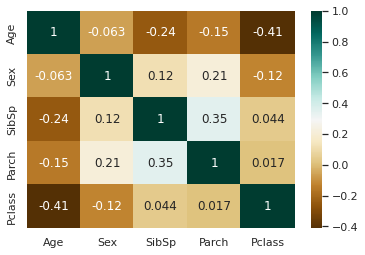

In [ ]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True) # annot : 위에 값을 써줌 
# AGE는 SEX와는 연관이 적지만, 나머지와는 꽤 높음 음의 상관관계 ㅇ
# The strategy is to fill Age with the median age of similar rows according to Pclass, Parch and SibSp

In [ ]:
# Filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age :
  age_med = dataset['Age'].median()
  age_pred = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp']) & (dataset['Parch']==dataset.iloc[i]['Parch']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
  if not np.isnan(age_pred) :
    dataset['Age'].iloc[i] = age_pred # 세가지 변수값이 겹치는 데이터가 있고 해당 데이터의 AGE값이 null값이 아니라면 해당 값으로 missing을 채우고
  else :
    dataset['Age'].iloc[i] = age_med # 아니라면 median값으로 대체

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


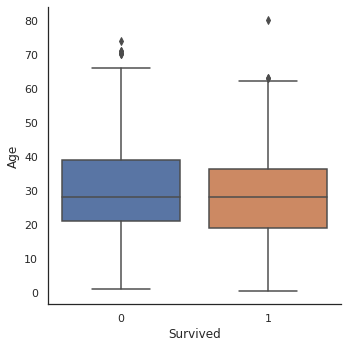

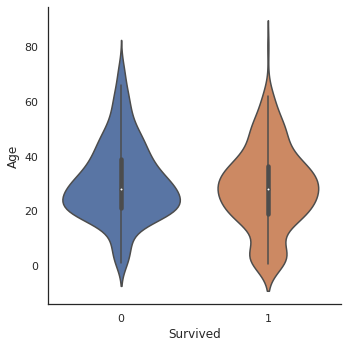

In [ ]:
g = sns.factorplot(x='Survived', y='Age', data=train, kind='box')
g = sns.factorplot(x="Survived", y = 'Age', data=train, kind='violin')

### 5. Feature Engineering
5.1 Name / Title

In [ ]:
dataset['Name'].head

<bound method NDFrame.head of 0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
                              ...                        
1294                                   Spector, Mr. Woolf
1295                         Oliva y Ocana, Dona. Fermina
1296                         Saether, Mr. Simon Sivertsen
1297                                  Ware, Mr. Frederick
1298                             Peter, Master. Michael J
Name: Name, Length: 1299, dtype: object>

In [ ]:
# Get Title from Name 
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

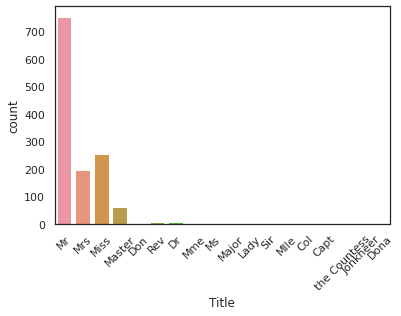

In [ ]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

# 17 titles, 앞에 4개가 가장 많이 사용됨 => 통일하자

In [ ]:
# convert to categorical values Title
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


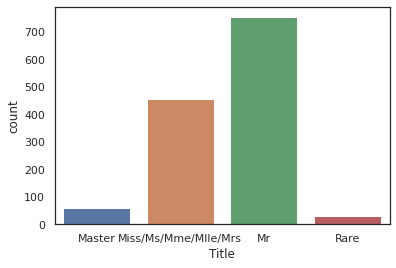

In [ ]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


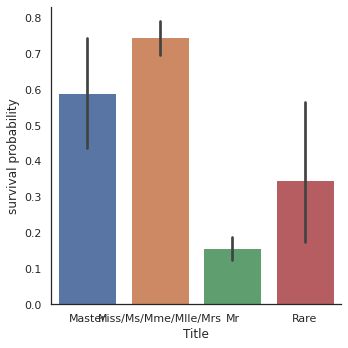

In [ ]:
g = sns.factorplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])
g = g.set_ylabels("survival probability")

# Rare title : 어린이가 많았음 => women and children firtst trend 존재

In [ ]:
# Drop Name variable
dataset.drop(labels = ['Name'], axis=1, inplace = True)

In [ ]:
# 5.2 Family size
## 예상 : 가족단위면 대피에 더 어려움이 있었을 것 => Fsize 변수이용하고자함
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


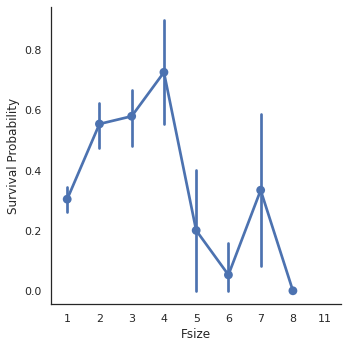

In [ ]:
g = sns.factorplot(x='Fsize', y="Survived", data=dataset)
g = g.set_ylabels("Survival Probability")

# 확실히 가족 사이즈가 생존에 영향을 미치는 것으로 파악 -> 4가지 카테고리로 나눠서 보자

In [ ]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s : 1 if s==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s : 1 if s ==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s : 1 if 3 <= s <= 4  else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s : 1 if s >= 5 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

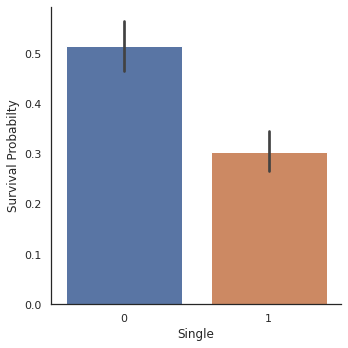

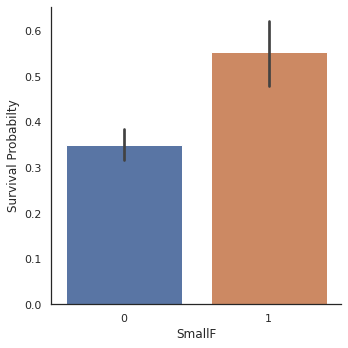

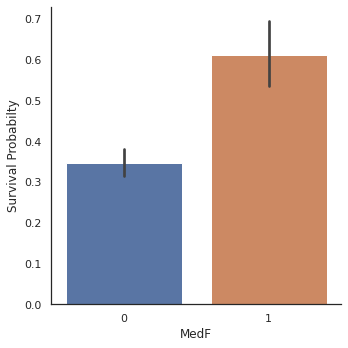

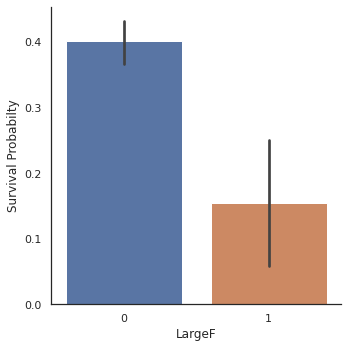

In [ ]:
g = sns.factorplot(x="Single", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probabilty")
g = sns.factorplot(x="SmallF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probabilty")
g = sns.factorplot(x="MedF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probabilty")
g = sns.factorplot(x="LargeF", y="Survived", data=dataset, kind="bar")
g = g.set_ylabels("Survival Probabilty")

# small and medium size families have more chance to survive than single passenger and large families

In [ ]:
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix="Em")
# pd.get_dummies() : prefix option : 더미변수 생성할때 변수 앞에 붙일 단어 지정

In [ ]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,2,0,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,2,0,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,1,1,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,2,0,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,1,1,0,0,0,0,0,1,0,0,0,1


In [ ]:
dataset.describe

<bound method NDFrame.describe of       PassengerId  Survived  Pclass  Sex  ...  Title_3  Em_C  Em_Q Em_S
0               1       0.0       3    0  ...        0     0     0    1
1               2       1.0       1    1  ...        0     1     0    0
2               3       1.0       3    1  ...        0     0     0    1
3               4       1.0       1    1  ...        0     0     0    1
4               5       0.0       3    0  ...        0     0     0    1
...           ...       ...     ...  ...  ...      ...   ...   ...  ...
1294         1305       NaN       3    0  ...        0     0     0    1
1295         1306       NaN       1    1  ...        1     1     0    0
1296         1307       NaN       3    0  ...        0     0     0    1
1297         1308       NaN       3    0  ...        0     0     0    1
1298         1309       NaN       3    0  ...        0     1     0    0

[1299 rows x 22 columns]>

In [ ]:
# 5.3 Cabin
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [ ]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [ ]:
dataset['Cabin'].isnull().sum()

1007

In [ ]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [ ]:
# Replace the Cabin number by the type of cabin 'X' if not
# 
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

In [ ]:
dataset.Cabin.head()

0    X
1    C
2    X
3    C
4    X
Name: Cabin, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


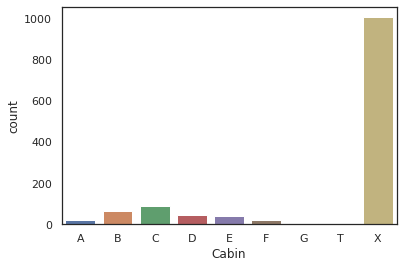

In [ ]:
g = sns.countplot(dataset["Cabin"], order=['A', "B", "C", "D", "E", 'F', 'G', 'T','X'])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


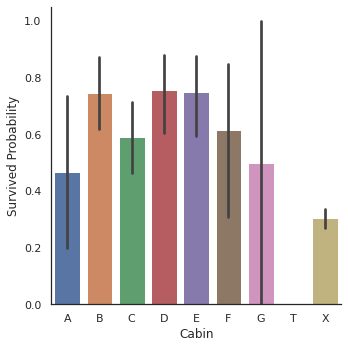

In [ ]:
g = sns.factorplot(y="Survived", x = "Cabin", data = dataset, kind="bar", order=['A', "B", "C", "D", "E", 'F', 'G', 'T','X'])
g = g.set_ylabels("Survived Probability")

# Cabin에 값을 가진 인원이 굉장히 많아서 편차가 굉장히 크긴하지만 확실히 X가 아닌 경우에 생존확률이 높은 것은 확인됨
# 특히 B, D, E, F

In [ ]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix="Cabin")

In [ ]:
# 5.4 Ticket
dataset["Ticket"].head()
# 추측 : same prefix를 갖는 티켓들은 아마도 같은 Cabin으로 배정됐을 확률 ㅇ
# prefix같으면 생존확률도 비슷할 가능성 ㅇ
# 결정 : replace the Ticket feature column by the ticket prefix

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [ ]:
## Treat Ticket by extracting the ticket prefix. when there is no prefix it returns X
Ticket = []
for i in list(dataset.Ticket) :
  if not i.isdigit() :
    Ticket.append(i.replace(".","").replace("/","").strip().split(" ")[0]) # Take prefix
  else :
    Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

# strip() : 양옆의 여백을 잘라줌
# split(" ") : 공백을 기준으로 분할해줌

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [ ]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [ ]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset['Pclass'].astype("category")
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix="Pc")

In [ ]:
# Drop useless variables
dataset.drop(labels = ['PassengerId'], axis=1, inplace=True)

In [ ]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,T_A,T_A4,T_A5,T_AQ3,T_AQ4,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_LP,T_PC,T_PP,T_PPP,T_SC,T_SCA3,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


# 6. Modeling

In [ ]:
# seperate train dataset and test dataset

train = dataset[:train_len] # train_len : 위에서 지정했던 trainset's length
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# seperate train features and label
train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']

X_train = train.drop(labels = ['Survived'], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# 6.1 Simple modeling
#6.1.1 Cross validate models
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


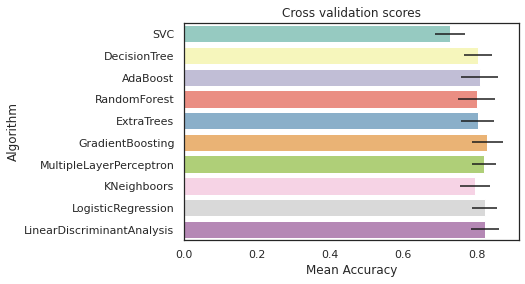

In [ ]:
# Modeling step Test different algorithms
rs = 2
classifiers = []
classifiers.append(SVC(random_state=rs))
classifiers.append(DecisionTreeClassifier(random_state=rs))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=rs),random_state=rs,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=rs))
classifiers.append(ExtraTreesClassifier(random_state=rs))
classifiers.append(GradientBoostingClassifier(random_state=rs))
classifiers.append(MLPClassifier(random_state=rs))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=rs))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
  cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring="accuracy", cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results :
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means, "CrossValerrors":cv_std, "Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, palette="Set3", orient="h", **{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

# 내 경우는 아니지만 캐글 커리큘럼에서는 성능이 잘 나온 'SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosint classifier'를 앙상블하기로 결정

In [ ]:
# Hyperparameter tunning for best models
# grid search를 통한 결정 => 오래걸리므로 주의
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING
# AdaBoost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {'base_estimator__criterion' : ['gini', 'entropy'],
                  'base_estimator__splitter':['best','random'], 
                  'algorithm':['SAMME', 'SAMME.R'], 
                  "n_estimators":[1,2], 
                  'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3 ,1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

In [ ]:
gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    8.5s finished


In [ ]:
gsadaDTC.best_score_

0.82073544433095

In [ ]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

# search grid for optimal parameters
ex_param_grid = {"max_depth" : [None],
                 "max_features": [1,3,10],
                 "min_samples_split":[2,3,10],
                 "min_samples_leaf":[1,3,10],
                 "bootstrap":[False],
                 "n_estimators":[100,300],
                 "criterion":['gini']}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.6min finished


0.8308605720122575

In [ ]:
ExtC_best = gsExtC.best_estimator_

In [ ]:
# RFC Parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth" : [None],
                 "max_features": [1,3,10],
                 "min_samples_split":[2,3,10],
                 "min_samples_leaf":[1,3,10],
                 "bootstrap":[False],
                 "n_estimators":[100,300],
                 "criterion":['gini']}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   33.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.7min finished


0.8343079673135854

In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ['deviance'],
                 'n_estimators' : [100,200,300],
                 'learning_rate' : [0.1,0.05, 0.01],
                 'max_depth' : [4, 8],
                 'min_samples_leaf': [100,150],
                 'max_features': [0.3, 0.1]}
gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=kfold, scoring='accuracy',
                     n_jobs=4, verbose=1) # verbose : logging을 출력할지말지

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   33.2s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:  1.1min finished


0.8331460674157304

In [ ]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel':['rbf'],
                  'gamma' : [0.001, 0.01, 0.1, 1],
                  'C' : [1,10,50,100,200,300,1000]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv=kfold,
                      scoring='accuracy', n_jobs=4, verbose=1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   32.8s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   55.4s finished


0.8331332992849847

In [ ]:
# plot learning curves
# : learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy
def plot_learning_curve(estimator, title, X, y,ylim=None, cv=None, 
                        n_jobs=-1, train_sizes= np.linspace(.1,1.0,5)) :
                        """Generate a simple plot of the test and training learning curve"""
                        plt.figure()
                        plt.title(title)
                        if ylim is not None :
                          plt.ylim(*ylim)
                        plt.xlabel("Training examples")
                        plt.ylabel("Score")
                        train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                        train_sizes=train_sizes)
                        train_scores_mean = np.mean(train_scores, axis=1)
                        train_scores_std = np.std(train_scores, axis=1)
                        test_scores_mean = np.mean(test_scores, axis=1)
                        test_scores_std = np.std(test_scores, axis=1)
                        plt.grid()

                        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + test_scores_std, alpha=0.1, color='r')
                        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')
                        plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training score")
                        plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label ='Cross-validation score')
                        plt.legend(loc='best')
                        return plt

In [ ]:
# 위의 코드에서 모르는 것들 모아서 해보기(연습장)
np.linspace(0.1, 1, 5) # 0.1에서 1까지를 5개 구간으로 등분

fill_between()

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

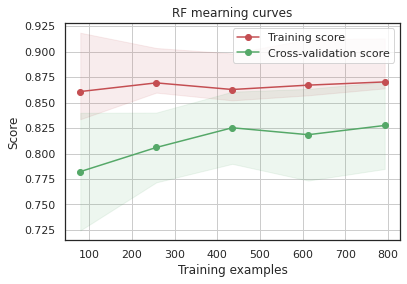

In [ ]:
g = plot_learning_curve(gsRFC.best_estimator_, "RF mearning curves", X_train, Y_train, cv=kfold)

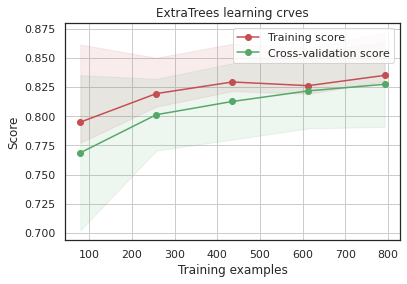

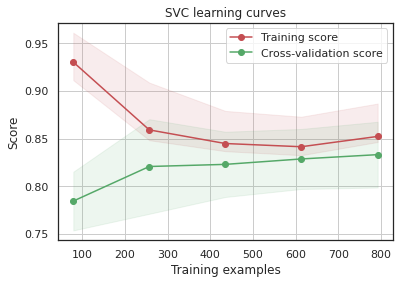

In [ ]:
g = plot_learning_curve(gsExtC.best_estimator_, "ExtraTrees learning crves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)

# SVC and ExtraTrees classifiers seem to better generalize the prediction since the training and cross-validation curves are close together.

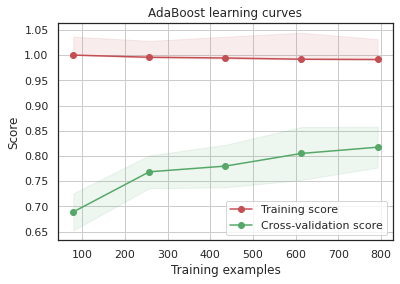

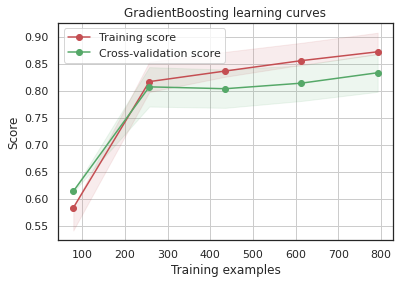

In [ ]:
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

# GradientBoosting and Adaboost classifiers tend to overfit the training set.
# According to the growing cross-validation curves GradientBoosting and Adaboost could perform better with more training examples

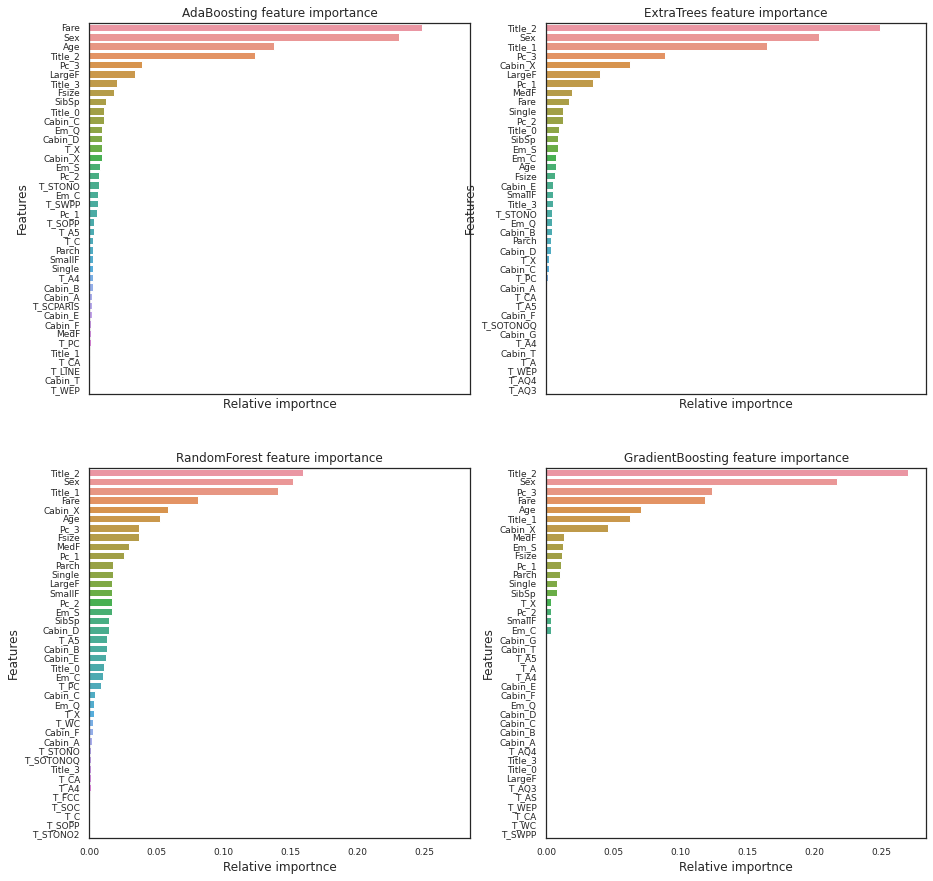

In [ ]:
# 6.1.4 Feature importance of tree based classifiers

nrows = ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(15,15))

names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best),("RandomForest", RFC_best), ("GradientBoosting", GBC_best)]

nclassifier = 0
for row in range(nrows) :
  for col in range(ncols) :
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40],
                    x=classifier.feature_importances_[indices][:40],
                    orient='h', ax=axes[row][col])
    g.set_xlabel("Relative importnce", fontsize=12)
    g.set_ylabel("Features", fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name+" feature importance")
    nclassifier +=1

  
# four classifiers have differnt top features according to the relative importance.
# It means that their predictions are not based on the smae features
# common important features for the classification : Fare, Title_2(성별과 관련ㅇ), Age, Sex

"""
1. Pc_1, Pc_2, Pc_3 and Fare refer to the general social standing of passengers.
2. Sex and Title_2 (Mrs/Mlle/Mme/Miss/Ms) and Title_3 (Mr) refer to the gender.
3. Age and Title_1 (Master) refer to the age of passengers.
4. Fsize, LargeF, MedF, Single refer to the size of the passenger family.
=> 성별, 나이, 가족 사이즈와 사회적 지위 중요도 >>> location in the boat
""" 

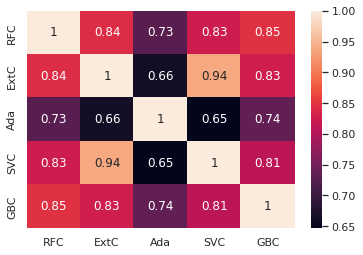

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

# Concatenate all calssifier results
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_SVMC, test_Survived_GBC], axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

# Ada boost 제외하고 나머지는 결과가 비슷해보임
# 다른 모ㅔㄷㄹ들끼리 다른것은 -> 앙상블해서 vote로 결정하고자함

In [ ]:
ensemble_results

,RFC,ExtC,Ada,SVC,GBC
0,0,0,0,0,0
1,0,0,0,1,0
2,0,0,0,0,0
3,0,0,1,0,0
4,1,1,0,1,0
...,...,...,...,...,...
413,0,0,0,0,0
414,1,1,1,1,1
415,0,0,0,0,0
416,0,0,0,0,0


In [ ]:
# 6.2 Ensemble modeling
# 6.2.1 Combining models - voting
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac',ada_best), ('gbc',GBC_best)],
                           voting = 'soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)


In [ ]:
# 6.3 Prediction
# 6.3.1 Predict and Submit results

test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest, test_Survived], axis=1)

results.to_csv("ensemble_python_voting.csv", index=False)